In [239]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.model_selection import train_test_split,RepeatedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
from sklearn.externals import joblib

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import matplotlib.pyplot as plt
#import xgboost as xgb
%matplotlib inline

In [2]:
#dataframe final
df_final = pd.read_csv("../data/DF_train15_skempiAB_modeller_final.csv",index_col=0)



pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns

In [3]:
X = df_final.drop('ddG_exp',axis=1).astype(float)
y = df_final['ddG_exp']

In [4]:
# binned split
bins = np.linspace(0, len(X), 200)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)   

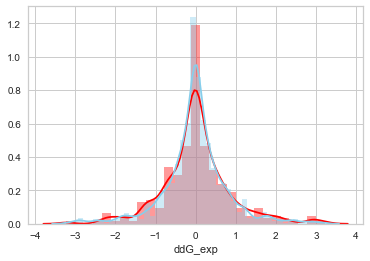

In [5]:
sns.distplot( y_test , color="red", label="ddG_exp_test")
sns.distplot( y_train , color="skyblue", label="ddG_exp_train")

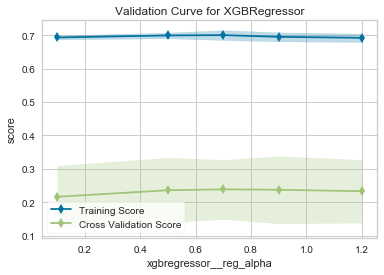

In [67]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()
#2)
lr_model = XGBRegressor(random_state=1212,n_jobs=-1,n_estimators=100)
#3) Crear pipeline
pipeline1 = make_pipeline(selector,lr_model)

viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="xgbregressor__reg_alpha",
    param_range=[0.1,0.5,0.7,0.9,1.2], cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [39]:
XGBRegressor?

In [232]:
#1)
selector = VarianceThreshold()
#2)
xg_model = XGBRegressor(random_state=1212)
#3) Crear pipeline
pipeline1 = make_pipeline(selector,xg_model)
# grid params

param_grid = {'xgbregressor__colsample_bytree': [0.3],
	'xgbregressor__subsample': [0.5],
	'xgbregressor__n_estimators':[100],
	'xgbregressor__max_depth': [6],
    'xgbregressor__gamma': [3],
    'xgbregressor__learning_rate': [0.07],
    'xgbregressor__min_child_weight':[20],
    'xgbregressor__reg_lambda': [2.7],
    'xgbregressor__reg_alpha': [1.9],
    'variancethreshold__threshold':[0.0]    
    }

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  50 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1c30cb0f28>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, m...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'xgbregressor__colsample_bytree': [0.3], 'xgbregressor__subsample': [0.5], 'xgbregressor__n_estimators': [100], 'xgbregressor__max_depth': [6], 'xgbregressor__gamma': [3], 'xgbregressor__learning_rate': [0.07], 'xgbregressor__min_child_weight': [20], 'xgbregressor__reg_lambda': [2.7], 'xgbregressor__reg_alpha': [1.9], 'variancethreshold__threshold': [0.0]},
       pre_dispatch='2*n_jobs', ref

In [233]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid1.score(X_test,y_test))
print('R2 train',grid1.score(X_train,y_train))

CV test RMSE 0.722215 +/- 0.268764
CV train RMSE 0.623878 +/- 0.106399
CV test r2 0.210675 +/- 0.055915
CV train r2 0.412725 +/- 0.015067
0.2020505511830468
 {'variancethreshold__threshold': 0.0, 'xgbregressor__colsample_bytree': 0.3, 'xgbregressor__gamma': 3, 'xgbregressor__learning_rate': 0.07, 'xgbregressor__max_depth': 6, 'xgbregressor__min_child_weight': 20, 'xgbregressor__n_estimators': 100, 'xgbregressor__reg_alpha': 1.9, 'xgbregressor__reg_lambda': 2.7, 'xgbregressor__subsample': 0.5}

RMSE for test dataset: 0.73
RMSE for train dataset: 0.61
pearson corr  0.571109
R2 test 0.30001933669480507
R2 train 0.43816294247399157


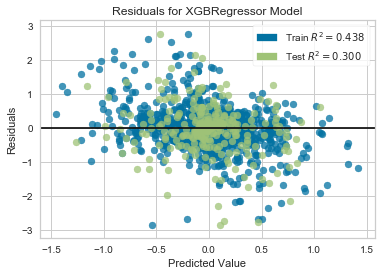

In [234]:
visualizer = ResidualsPlot(grid1.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

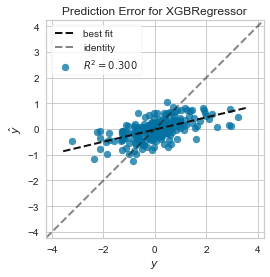

In [235]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof() 

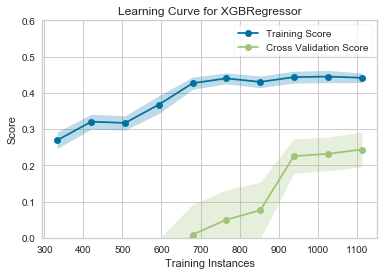

In [236]:
viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='r2',train_sizes=np.linspace(0.3, 1.0, 10))
viz.fit(X, y)
plt.ylim(0,0.6)
viz.poof()

In [237]:
final_xgb = grid1.best_estimator_.fit(X,y)

In [240]:
# save final model

joblib.dump(final_xgb, 'XGBmodel_train15skempiAB_FINAL.pkl')

['XGBmodel_train15skempiAB_FINAL.pkl']

In [33]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self, early_stopping_rounds=5, test_size=0.1, 
                 eval_metric='rmse', **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='rmse'        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [76]:
https://www.kaggle.com/c/santander-customer-satisfaction/discussion/20662
    https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html

0.9136635788049788

In [52]:
print('CV test RMSE',np.sqrt(-grid.best_score_))
print('CV train RMSE',np.sqrt(-grid.cv_results_['mean_train_score'].max()))

#print('Training score (r2): {}'.format(r2_score(X_train, y_train)))
#print('Test score (r2): {}'.format(r2_score(X_test, y_test)))

print(grid.best_params_)
y_test_pred = grid.best_estimator_.predict(X_test)
y_train_pred = grid.best_estimator_.predict(X_train)
print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("Root mean square error for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr: ",np.corrcoef(y_test_pred,y_test)[0][1])

CV test RMSE 0.9189926858129649
CV train RMSE 0.7875286254308612
{'xgb__colsample_bytree': 0.9, 'xgb__gamma': 0.9, 'xgb__learning_rate': 0.025, 'xgb__max_depth': 12, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 30}

Root mean square error for test dataset: 1.24
Root mean square error for train dataset: 1.06
pearson corr:  0.5703248908726392


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


[0]	validation_0-rmse:0.571404
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.570291
[2]	validation_0-rmse:0.566001
[3]	validation_0-rmse:0.561554
[4]	validation_0-rmse:0.551783
[5]	validation_0-rmse:0.54901
[6]	validation_0-rmse:0.546974
[7]	validation_0-rmse:0.543284
[8]	validation_0-rmse:0.541481
[9]	validation_0-rmse:0.538126
[10]	validation_0-rmse:0.532702
[11]	validation_0-rmse:0.527458
[12]	validation_0-rmse:0.524775
[13]	validation_0-rmse:0.524164
[14]	validation_0-rmse:0.524871
[15]	validation_0-rmse:0.521036
[16]	validation_0-rmse:0.519074
[17]	validation_0-rmse:0.516307
[18]	validation_0-rmse:0.513641
[19]	validation_0-rmse:0.511073
[20]	validation_0-rmse:0.507002
[21]	validation_0-rmse:0.499601
[22]	validation_0-rmse:0.498624
[23]	validation_0-rmse:0.497674
[24]	validation_0-rmse:0.496348
[25]	validation_0-rmse:0.493793
[26]	validation_0-rmse:0.492966
[27]	validation_0-rmse:0.491411
[28]	validation_0-rmse:0.491984
[29]	validation_0-r

[1]	validation_0-rmse:1.77105
[2]	validation_0-rmse:1.75968
[3]	validation_0-rmse:1.74973
[4]	validation_0-rmse:1.74405
[5]	validation_0-rmse:1.73753
[6]	validation_0-rmse:1.72876
[7]	validation_0-rmse:1.72457
[8]	validation_0-rmse:1.71931
[9]	validation_0-rmse:1.7138
[10]	validation_0-rmse:1.71054
[11]	validation_0-rmse:1.70206
[12]	validation_0-rmse:1.69683
[13]	validation_0-rmse:1.69341
[14]	validation_0-rmse:1.68925
[15]	validation_0-rmse:1.68688
[16]	validation_0-rmse:1.68405
[17]	validation_0-rmse:1.68176
[18]	validation_0-rmse:1.67839
[19]	validation_0-rmse:1.67426
[20]	validation_0-rmse:1.67141
[21]	validation_0-rmse:1.66772
[22]	validation_0-rmse:1.66321
[23]	validation_0-rmse:1.66058
[24]	validation_0-rmse:1.6599
[25]	validation_0-rmse:1.65934
[26]	validation_0-rmse:1.65488
[27]	validation_0-rmse:1.65416
[28]	validation_0-rmse:1.65458
[29]	validation_0-rmse:1.65512
[0]	validation_0-rmse:1.70341
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-r

[15]	validation_0-rmse:1.67882
[16]	validation_0-rmse:1.67576
[17]	validation_0-rmse:1.67231
[18]	validation_0-rmse:1.66562
[19]	validation_0-rmse:1.65914
[20]	validation_0-rmse:1.65282
[21]	validation_0-rmse:1.64598
[22]	validation_0-rmse:1.64336
[23]	validation_0-rmse:1.63756
[24]	validation_0-rmse:1.63227
[25]	validation_0-rmse:1.63085
[26]	validation_0-rmse:1.62506
[27]	validation_0-rmse:1.61895
[28]	validation_0-rmse:1.61297
[29]	validation_0-rmse:1.61275
[0]	validation_0-rmse:1.72878
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.71003
[2]	validation_0-rmse:1.6905
[3]	validation_0-rmse:1.67345
[4]	validation_0-rmse:1.65629
[5]	validation_0-rmse:1.64076
[6]	validation_0-rmse:1.61805
[7]	validation_0-rmse:1.60031
[8]	validation_0-rmse:1.57976
[9]	validation_0-rmse:1.56189
[10]	validation_0-rmse:1.54311
[11]	validation_0-rmse:1.52753
[12]	validation_0-rmse:1.50976
[13]	validation_0-rmse:1.49753
[14]	validation_0-rmse:1.48495
[15]	validation_0

[9]	validation_0-rmse:1.08553
[10]	validation_0-rmse:1.08033
[11]	validation_0-rmse:1.07399
[12]	validation_0-rmse:1.06841
[13]	validation_0-rmse:1.06428
[14]	validation_0-rmse:1.06114
[15]	validation_0-rmse:1.05849
[16]	validation_0-rmse:1.0545
[17]	validation_0-rmse:1.05115
[18]	validation_0-rmse:1.04905
[19]	validation_0-rmse:1.04305
[20]	validation_0-rmse:1.04057
[21]	validation_0-rmse:1.04075
[22]	validation_0-rmse:1.03726
[23]	validation_0-rmse:1.03802
[24]	validation_0-rmse:1.03304
[25]	validation_0-rmse:1.0314
[26]	validation_0-rmse:1.02918
[27]	validation_0-rmse:1.02615
[28]	validation_0-rmse:1.02292
[29]	validation_0-rmse:1.0208
[0]	validation_0-rmse:1.58849
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.57528
[2]	validation_0-rmse:1.55872
[3]	validation_0-rmse:1.53952
[4]	validation_0-rmse:1.52939
[5]	validation_0-rmse:1.51896
[6]	validation_0-rmse:1.50569
[7]	validation_0-rmse:1.4976
[8]	validation_0-rmse:1.48508
[9]	validation_0-rms

[29]	validation_0-rmse:1.66606
[0]	validation_0-rmse:1.54808
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.54114
[2]	validation_0-rmse:1.53312
[3]	validation_0-rmse:1.52919
[4]	validation_0-rmse:1.52211
[5]	validation_0-rmse:1.51836
[6]	validation_0-rmse:1.51054
[7]	validation_0-rmse:1.50426
[8]	validation_0-rmse:1.50103
[9]	validation_0-rmse:1.49823
[10]	validation_0-rmse:1.49525
[11]	validation_0-rmse:1.49338
[12]	validation_0-rmse:1.48975
[13]	validation_0-rmse:1.48157
[14]	validation_0-rmse:1.47854
[15]	validation_0-rmse:1.47482
[16]	validation_0-rmse:1.47202
[17]	validation_0-rmse:1.46935
[18]	validation_0-rmse:1.4663
[19]	validation_0-rmse:1.46389
[20]	validation_0-rmse:1.46091
[21]	validation_0-rmse:1.45804
[22]	validation_0-rmse:1.45511
[23]	validation_0-rmse:1.45198
[24]	validation_0-rmse:1.45039
[25]	validation_0-rmse:1.44956
[26]	validation_0-rmse:1.44778
[27]	validation_0-rmse:1.44513
[28]	validation_0-rmse:1.44354
[29]	validation_0

[24]	validation_0-rmse:1.28151
[25]	validation_0-rmse:1.27299
[26]	validation_0-rmse:1.27038
[27]	validation_0-rmse:1.26161
[28]	validation_0-rmse:1.25337
[29]	validation_0-rmse:1.24653
[0]	validation_0-rmse:1.47558
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.46102
[2]	validation_0-rmse:1.4506
[3]	validation_0-rmse:1.4376
[4]	validation_0-rmse:1.42737
[5]	validation_0-rmse:1.40944
[6]	validation_0-rmse:1.39596
[7]	validation_0-rmse:1.3747
[8]	validation_0-rmse:1.36019
[9]	validation_0-rmse:1.34824
[10]	validation_0-rmse:1.33581
[11]	validation_0-rmse:1.32689
[12]	validation_0-rmse:1.3086
[13]	validation_0-rmse:1.29949
[14]	validation_0-rmse:1.29641
[15]	validation_0-rmse:1.28512
[16]	validation_0-rmse:1.26905
[17]	validation_0-rmse:1.25584
[18]	validation_0-rmse:1.25215
[19]	validation_0-rmse:1.24172
[20]	validation_0-rmse:1.23854
[21]	validation_0-rmse:1.22859
[22]	validation_0-rmse:1.22066
[23]	validation_0-rmse:1.21224
[24]	validation_0-rm

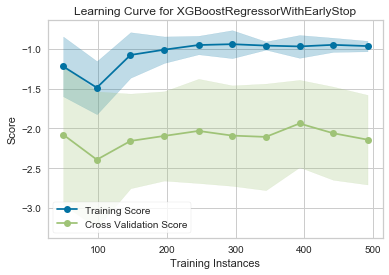

In [60]:
viz = LearningCurve(grid.best_estimator_, cv=5, nthreads=10,scoring='neg_mean_squared_error',train_sizes=np.linspace(.1, 1.0, 10))
viz.fit(X, y)
viz.poof()

# Metodologia completa Gridsearch , early stop

In [30]:
XGBRegressor?

[0]	validation_0-rmse:0.973457
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.953427
[2]	validation_0-rmse:0.901668
[3]	validation_0-rmse:0.871449
[4]	validation_0-rmse:0.866862
[5]	validation_0-rmse:0.858654
[6]	validation_0-rmse:0.860552
[7]	validation_0-rmse:0.83181
[8]	validation_0-rmse:0.837552
[9]	validation_0-rmse:0.840062
[10]	validation_0-rmse:0.84327
[11]	validation_0-rmse:0.834652
[12]	validation_0-rmse:0.845716
Stopping. Best iteration:
[7]	validation_0-rmse:0.83181

[0]	validation_0-rmse:1.81881
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.77829
[2]	validation_0-rmse:1.73722
[3]	validation_0-rmse:1.65957
[4]	validation_0-rmse:1.59658
[5]	validation_0-rmse:1.54923
[6]	validation_0-rmse:1.50634
[7]	validation_0-rmse:1.47258
[8]	validation_0-rmse:1.43183
[9]	validation_0-rmse:1.39987
[10]	validation_0-rmse:1.39822
[11]	validation_0-rmse:1.36319
[12]	validation_0-rmse:1.32197
[13]	validation_0-

[6]	validation_0-rmse:1.25903
[7]	validation_0-rmse:1.26041
[8]	validation_0-rmse:1.24783
[9]	validation_0-rmse:1.24814
[10]	validation_0-rmse:1.25895
[11]	validation_0-rmse:1.26697
[12]	validation_0-rmse:1.25877
[13]	validation_0-rmse:1.26712
Stopping. Best iteration:
[8]	validation_0-rmse:1.24783

[0]	validation_0-rmse:1.6578
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.58863
[2]	validation_0-rmse:1.5814
[3]	validation_0-rmse:1.56546
[4]	validation_0-rmse:1.54783
[5]	validation_0-rmse:1.52551
[6]	validation_0-rmse:1.52493
[7]	validation_0-rmse:1.51185
[8]	validation_0-rmse:1.516
[9]	validation_0-rmse:1.52053
[10]	validation_0-rmse:1.50422
[11]	validation_0-rmse:1.50946
[12]	validation_0-rmse:1.51031
[13]	validation_0-rmse:1.48993
[14]	validation_0-rmse:1.49076
[15]	validation_0-rmse:1.47926
[16]	validation_0-rmse:1.4699
[17]	validation_0-rmse:1.46173
[18]	validation_0-rmse:1.47403
[19]	validation_0-rmse:1.46906
[20]	validation_0-rmse:1.47716

[11]	validation_0-rmse:1.12286
[12]	validation_0-rmse:1.11329
[13]	validation_0-rmse:1.1128
[14]	validation_0-rmse:1.11115
[15]	validation_0-rmse:1.09482
[16]	validation_0-rmse:1.08544
[17]	validation_0-rmse:1.08625
[18]	validation_0-rmse:1.0875
[19]	validation_0-rmse:1.08307
[20]	validation_0-rmse:1.06057
[21]	validation_0-rmse:1.05427
[22]	validation_0-rmse:1.05773
[23]	validation_0-rmse:1.05615
[24]	validation_0-rmse:1.05278
[25]	validation_0-rmse:1.04786
[26]	validation_0-rmse:1.03118
[27]	validation_0-rmse:1.03151
[28]	validation_0-rmse:1.0311
[29]	validation_0-rmse:1.03706
[0]	validation_0-rmse:1.14094
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.12282
[2]	validation_0-rmse:1.10077
[3]	validation_0-rmse:1.09595
[4]	validation_0-rmse:1.08984
[5]	validation_0-rmse:1.06744
[6]	validation_0-rmse:1.0742
[7]	validation_0-rmse:1.03054
[8]	validation_0-rmse:1.02063
[9]	validation_0-rmse:1.01642
[10]	validation_0-rmse:0.985227
[11]	validation_0-r

[12]	validation_0-rmse:1.42193
Stopping. Best iteration:
[7]	validation_0-rmse:1.4193

[0]	validation_0-rmse:1.57746
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.53796
[2]	validation_0-rmse:1.52974
[3]	validation_0-rmse:1.50942
[4]	validation_0-rmse:1.48675
[5]	validation_0-rmse:1.44674
[6]	validation_0-rmse:1.43817
[7]	validation_0-rmse:1.43118
[8]	validation_0-rmse:1.43625
[9]	validation_0-rmse:1.44407
[10]	validation_0-rmse:1.46107
[11]	validation_0-rmse:1.44922
[12]	validation_0-rmse:1.43779
Stopping. Best iteration:
[7]	validation_0-rmse:1.43118

[0]	validation_0-rmse:1.76455
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.70987
[2]	validation_0-rmse:1.68943
[3]	validation_0-rmse:1.6487
[4]	validation_0-rmse:1.6234
[5]	validation_0-rmse:1.61333
[6]	validation_0-rmse:1.60382
[7]	validation_0-rmse:1.59217
[8]	validation_0-rmse:1.56031
[9]	validation_0-rmse:1.54704
[10]	validation_0-rmse:1.52993
[11]	v

[2]	validation_0-rmse:1.42607
[3]	validation_0-rmse:1.40766
[4]	validation_0-rmse:1.38621
[5]	validation_0-rmse:1.38514
[6]	validation_0-rmse:1.36983
[7]	validation_0-rmse:1.36209
[8]	validation_0-rmse:1.36362
[9]	validation_0-rmse:1.36181
[10]	validation_0-rmse:1.34443
[11]	validation_0-rmse:1.34488
[12]	validation_0-rmse:1.33636
[13]	validation_0-rmse:1.33902
[14]	validation_0-rmse:1.32766
[15]	validation_0-rmse:1.33448
[16]	validation_0-rmse:1.33118
[17]	validation_0-rmse:1.33224
[18]	validation_0-rmse:1.33337
[19]	validation_0-rmse:1.33198
Stopping. Best iteration:
[14]	validation_0-rmse:1.32766

[0]	validation_0-rmse:1.18337
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.18316
[2]	validation_0-rmse:1.17287
[3]	validation_0-rmse:1.16648
[4]	validation_0-rmse:1.17164
[5]	validation_0-rmse:1.17311
[6]	validation_0-rmse:1.16403
[7]	validation_0-rmse:1.15182
[8]	validation_0-rmse:1.13276
[9]	validation_0-rmse:1.1259
[10]	validation_0-rmse:1.1305

[15]	validation_0-rmse:1.65011
[16]	validation_0-rmse:1.64341
[17]	validation_0-rmse:1.64156
[18]	validation_0-rmse:1.64582
[19]	validation_0-rmse:1.65368
[20]	validation_0-rmse:1.64397
[21]	validation_0-rmse:1.64079
[22]	validation_0-rmse:1.65003
[23]	validation_0-rmse:1.64623
[24]	validation_0-rmse:1.64073
[25]	validation_0-rmse:1.63623
[26]	validation_0-rmse:1.65355
[27]	validation_0-rmse:1.64622
[28]	validation_0-rmse:1.63074
[29]	validation_0-rmse:1.63574
[0]	validation_0-rmse:1.67651
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.62601
[2]	validation_0-rmse:1.59273
[3]	validation_0-rmse:1.57224
[4]	validation_0-rmse:1.53591
[5]	validation_0-rmse:1.52096
[6]	validation_0-rmse:1.48004
[7]	validation_0-rmse:1.4738
[8]	validation_0-rmse:1.44804
[9]	validation_0-rmse:1.44268
[10]	validation_0-rmse:1.42719
[11]	validation_0-rmse:1.42158
[12]	validation_0-rmse:1.40851
[13]	validation_0-rmse:1.40101
[14]	validation_0-rmse:1.38638
[15]	validation_0

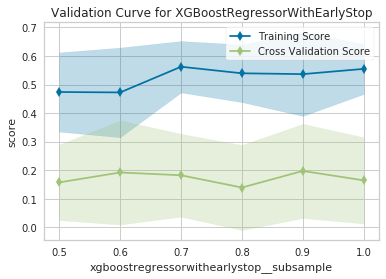

In [34]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()
#2)
lr_model = XGBoostRegressorWithEarlyStop(random_state=1212,n_jobs=-1,n_estimators=30)
#3) Crear pipeline
pipeline1 = make_pipeline(selector,lr_model)

viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="xgboostregressorwithearlystop__subsample",
    param_range=[0.5,0.6,0.7,0.8,0.9,1], cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [142]:
import os

if __name__ == "__main__":
    # NOTE: on posix systems, this *has* to be here and in the
    # `__name__ == "__main__"` clause to run XGBoost in parallel processes
    # using fork, if XGBoost was built with OpenMP support. Otherwise, if you
    # build XGBoost without OpenMP support, you can use fork, which is the
    # default backend for joblib, and omit this.
    try:
        from multiprocessing import set_start_method
    except ImportError:
        raise ImportError("Unable to import multiprocessing.set_start_method."
                          " This example only runs on Python 3.4")
    #set_start_method("forkserver")

    import numpy as np
    import pandas as pd
    from pathlib import Path
    from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.datasets import load_boston
    import xgboost as xgb




    from sklearn.base import BaseEstimator
    from sklearn.model_selection import train_test_split
    from xgboost import XGBRegressor, XGBClassifier

    class XGBoostWithEarlyStop(BaseEstimator):
        def __init__(self, early_stopping_rounds=10, test_size=0.15, 
                     eval_metric='rmse', random_state=1212,**estimator_params):
            self.early_stopping_rounds = early_stopping_rounds
            self.test_size = test_size
            self.eval_metric=eval_metric='rmse'        
            if self.estimator is not None:
                self.set_params(**estimator_params)

        def set_params(self, **params):
            return self.estimator.set_params(**params)

        def get_params(self, **params):
            return self.estimator.get_params()

        def fit(self, X, y):
            x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
            self.estimator.fit(x_train, y_train, 
                               early_stopping_rounds=self.early_stopping_rounds, 
                               eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
            return self

        def predict(self, X):
            return self.estimator.predict(X)

    class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
        def __init__(self, *args, **kwargs):
            self.estimator = XGBRegressor()
            super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

    class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
        def __init__(self, *args, **kwargs):
            self.estimator = XGBClassifier()
            super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)


    # Load data
    ABPRED_DIR = Path().cwd().parent
    DATA = ABPRED_DIR / "data"

    #dataframe final
    df_final = pd.read_csv(DATA/"../data/DF_contact400_energy_sasa.FcorrZero.csv",index_col=0)
   
    pdb_names = df_final.index
    features_names = df_final.drop('ddG_exp',axis=1).columns

    # Data final
    X = df_final.drop('ddG_exp',axis=1).astype(float)
    y = df_final['ddG_exp']

    #Split data
    # split for final test
    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75,random_state=1212)

    njob = 4
    os.environ["OMP_NUM_THREADS"] = str(njob)  # or to whatever you want
    
    xgb_model = XGBoostRegressorWithEarlyStop()
    param_grid = {'colsample_bytree': [0.7],
	'subsample': [1],
	'n_estimators':[1000],
	'max_depth': [10],
    'gamma': [1],
    'learning_rate': [0.05],
    'min_child_weight':[1],
    'reg_lambda': [0],
    'reg_alpha': [10],
    'colsample_bylevel':[0.9],
    'random_state':[1212]}

    grid = GridSearchCV(xgb_model, param_grid, verbose=5, n_jobs=njob,cv=10,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
    grid.fit(X_train, y_train)


    # index of best scores
    rmse_bestCV_test_index = grid.cv_results_['mean_test_neg_mean_squared_error'].argmax()
    rmse_bestCV_train_index = grid.cv_results_['mean_train_neg_mean_squared_error'].argmax()
    r2_bestCV_test_index = grid.cv_results_['mean_test_r2'].argmax()
    r2_bestCV_train_index = grid.cv_results_['mean_train_r2'].argmax()
    # scores
    rmse_bestCV_test_score = grid.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
    rmse_bestCV_test_std = grid.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
    rmse_bestCV_train_score = grid.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
    rmse_bestCV_train_std = grid.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

    r2_bestCV_test_score = grid.cv_results_['mean_test_r2'][r2_bestCV_test_index]
    r2_bestCV_test_std = grid.cv_results_['std_test_r2'][r2_bestCV_test_index]
    r2_bestCV_train_score = grid.cv_results_['mean_train_r2'][r2_bestCV_train_index]
    r2_bestCV_train_std = grid.cv_results_['std_train_r2'][r2_bestCV_train_index]

    print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
    print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
    print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
    print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

    print(r2_bestCV_train_score-r2_bestCV_test_score)
    print("",grid.best_params_)
    y_test_pred = grid.best_estimator_.predict(X_test)
    y_train_pred = grid.best_estimator_.predict(X_train)
    print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
    print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
    print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.4s finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV test RMSE 1.219994 +/- 0.669392
CV train RMSE 0.966341 +/- 0.369554
CV test r2 0.261086 +/- 0.165682
CV train r2 0.572881 +/- 0.064955
0.3117953566700539
 {'colsample_bylevel': 0.9, 'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'random_state': 1212, 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 1}

RMSE for test dataset: 1.0
RMSE for train dataset: 0.75
pearson corr  0.662289


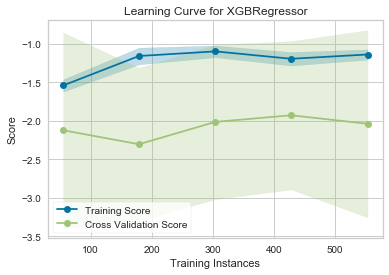

In [226]:

viz = LearningCurve(grid.best_estimator_, n_jobs=-1,cv=10, scoring='neg_mean_squared_error')
viz.fit(X, y)
viz.poof()

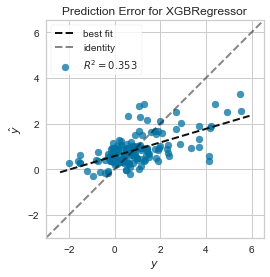

In [219]:
perror = PredictionError(grid.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

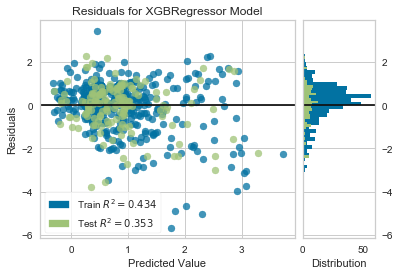

In [220]:
visualizer = ResidualsPlot(grid.best_estimator_)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


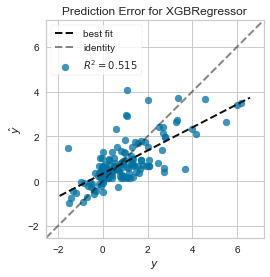

In [18]:
perror = PredictionError(model)

perror.fit(X_train_normal, y_train_normal)  # Fit the training data to the visualizer
perror.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
g = perror.poof()